In [1]:
#Importing Packages
import numpy as np
import xarray as xr
from tinygp import kernels, GaussianProcess
import jax
from jax import random
import jax.numpy as jnp
import numpyro.distributions as dist
import matplotlib.pyplot as plt
import arviz as az
from src.model_fitting_functions import run_inference
from src.examples_functions import hierarchical_model,truth_posterior_predictive,bias_posterior_predictive
from src.examples_functions import posterior_predictive_realisations_hierarchical_mean, posterior_predictive_realisations_hierarchical_var

plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.4

rng_key = random.PRNGKey(5)
rng_key, rng_key_ = random.split(rng_key)
jax.config.update("jax_enable_x64", True)

In [2]:
#Creating Underlying Process Data 

X1 = np.arange(0,105,2)
X2 = np.arange(0,105,2)
D = np.arange(0,100,1)

ds = xr.Dataset(
    coords=dict(
        X1=("X1", X1),
        X2=("X2", X2),
        D=("D", D),
    ),
)

ds_stacked = ds.stack(X=('X1', 'X2'))
X = np.array(list(map(np.array, ds_stacked.X.data)))

In [3]:
#Latent mean and variance for truth and bias processes
GP_T_MEAN = GaussianProcess(1 * kernels.ExpSquared(10),X,diag=1e-5,mean=1.0)
GP_T_LOGVAR = GaussianProcess(1 * kernels.ExpSquared(10),X,diag=1e-5,mean=-1.0)
GP_B_MEAN = GaussianProcess(1 * kernels.ExpSquared(40),X,diag=1e-5,mean=-1.0)
GP_B_LOGVAR = GaussianProcess(1 * kernels.ExpSquared(40),X,diag=1e-5,mean=-1.0)

MEAN_T = GP_T_MEAN.sample(rng_key)
rng_key, rng_key_ = random.split(rng_key)
LOGVAR_T = GP_T_LOGVAR.sample(rng_key)
rng_key, rng_key_ = random.split(rng_key)
MEAN_B = GP_B_MEAN.sample(rng_key)
rng_key, rng_key_ = random.split(rng_key)
LOGVAR_B = GP_B_LOGVAR.sample(rng_key)
MEAN_C = MEAN_T + MEAN_B
LOGVAR_C = LOGVAR_T + LOGVAR_B

ds_stacked["MEAN_T"]=(['X'],  MEAN_T)
ds_stacked["LOGVAR_T"]=(['X'],  LOGVAR_T)
ds_stacked["VAR_T"]=(['X'],  jnp.exp(LOGVAR_T))
ds_stacked["MEAN_B"]=(['X'],  MEAN_B)
ds_stacked["LOGVAR_B"]=(['X'],  LOGVAR_B)
ds_stacked["VAR_B"]=(['X'],  jnp.exp(LOGVAR_B))
ds_stacked["MEAN_C"]=(['X'],  MEAN_C)
ds_stacked["LOGVAR_C"]=(['X'],  LOGVAR_C)
ds_stacked["VAR_C"]=(['X'],  jnp.exp(LOGVAR_C))
ds = ds_stacked.unstack()

In [4]:
Normal_T = dist.Normal(ds.MEAN_T.data, jnp.sqrt(ds.VAR_T.data))
T = Normal_T.sample(rng_key,ds.D.shape)

Normal_C = dist.Normal(ds.MEAN_C.data, jnp.sqrt(ds.VAR_C.data))
C = Normal_C.sample(rng_key,ds.D.shape)

ds["T"]=(['D','X1','X2'],  T)
ds["C"]=(['D','X1','X2'],  C)

In [5]:
#Observations
da_obs = ds.T.isel(X1=slice(1,None,5),X2=slice(1,None,5))
X1_condition = (ds.X1<25) | (ds.X1>75) 
X2_condition = (ds.X2<25) | (ds.X2>75) 
da_obs = da_obs.where(X1_condition|X2_condition,drop=True)
da_obs_stacked = da_obs.stack(X=('X1', 'X2'))

#Climate model
da_climate = ds.C.isel(X1=slice(None,None,5),X2=slice(None,None,5))
da_climate_stacked = da_climate.stack(X=('X1', 'X2'))

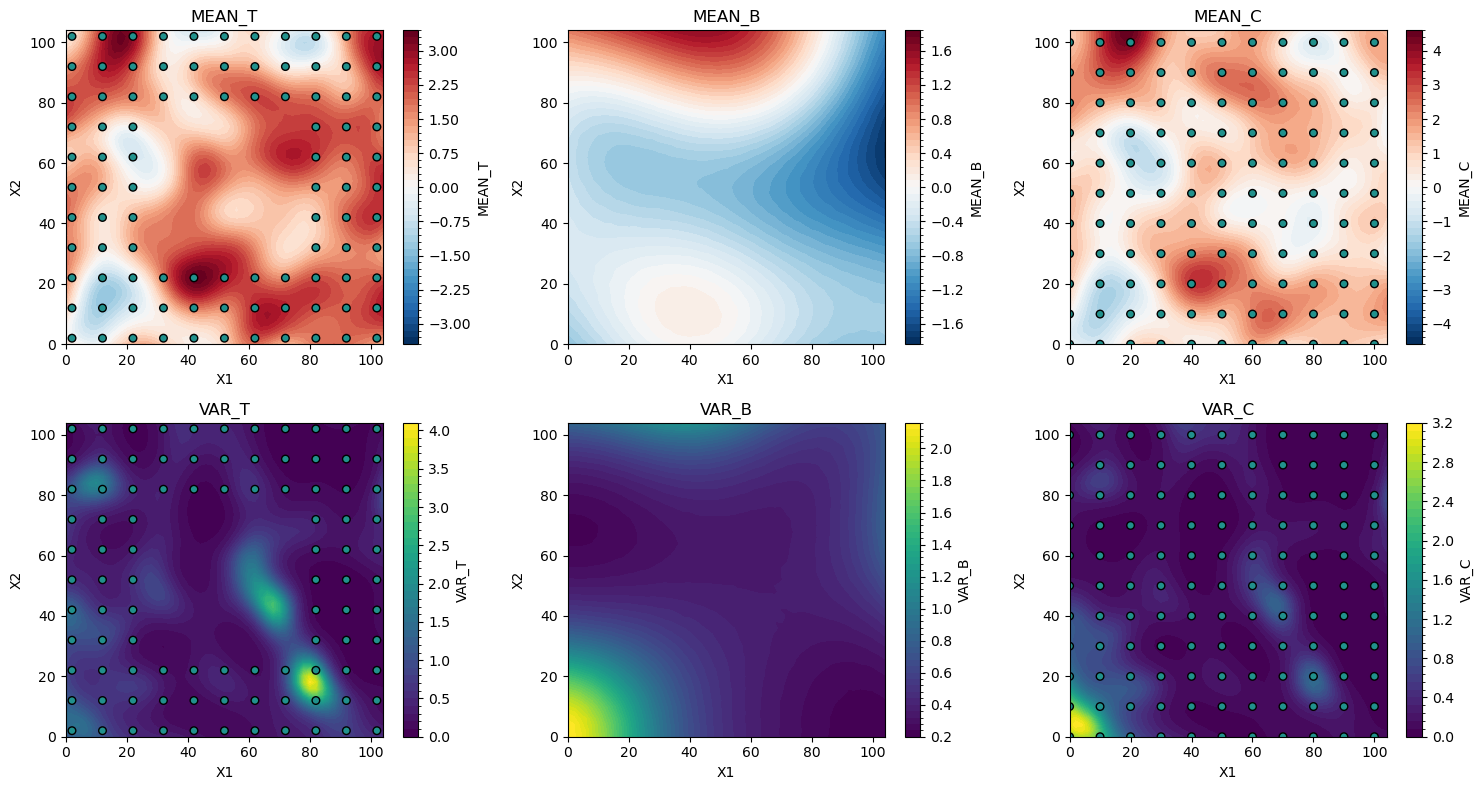

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
plots = []
variables = ['MEAN_T','MEAN_B','MEAN_C','VAR_T','VAR_B','VAR_C']

for i,var in zip(range(1, 7), variables):
    plt.subplot(2, 3, i)
    plots.append(
        ds[f'{var}'].plot.contourf(x='X1',y='X2',levels=50)
    )
    plt.title(var)

for i,var,da in zip([0,2],['T','C'],[da_obs,da_climate]):
    ax1 = axs.flatten()[i]
    ax2 = axs.flatten()[i+3]
    da = da.isel(D=0)
    da = da.where(da.isnull(),1)
    for ax in [ax1,ax2]:
        da.to_dataset().plot.scatter(x='X1',y='X2',hue=f'{var}',s=30, facecolors='none', edgecolors='k',add_colorbar=False, ax=ax, add_title=False)

plt.tight_layout()

In [7]:
ox = np.array(list(map(np.array, da_obs_stacked.dropna('X').X.data)))
cx = np.array(list(map(np.array, da_climate_stacked.X.data)))
odata = da_obs_stacked.dropna('X').data
cdata = da_climate_stacked.data

In [8]:
mcmc_hierarchical = run_inference(hierarchical_model, rng_key_, 1000, 2000, cx,cdata=cdata,ox=ox,odata=odata,noise=1e-5)

sample: 100%|██████████| 3000/3000 [05:34<00:00,  8.97it/s, 15 steps of size 2.17e-01. acc. prob=0.90]   



                       mean       std    median      5.0%     95.0%     n_eff     r_hat
     lvb_kern_var      3.14      2.13      2.61      0.36      5.96   1885.71      1.00
  lvb_lengthscale     57.61     20.30     56.31     22.28     87.72   2104.06      1.00
         lvb_mean     -0.41      0.97     -0.47     -1.95      1.18   1809.12      1.00
           lvc[0]      0.91      0.14      0.91      0.70      1.15   2271.49      1.00
           lvc[1]      0.88      0.13      0.88      0.67      1.10   1982.45      1.00
           lvc[2]      0.03      0.13      0.02     -0.20      0.24   2026.86      1.00
           lvc[3]     -0.12      0.14     -0.12     -0.34      0.12   2012.34      1.00
           lvc[4]     -0.18      0.14     -0.18     -0.39      0.07   2194.33      1.00
           lvc[5]     -1.62      0.13     -1.62     -1.83     -1.40   3106.01      1.00
           lvc[6]     -2.18      0.13     -2.19     -2.41     -1.97   2648.74      1.00
           lvc[7]     -1.66    

In [9]:
#Saving Output from MCMC
outfile_dir = '/home/jez/Bias_Correction/data/Examples_Output/'
idata_hierarchical = az.from_numpyro(
    mcmc_hierarchical,
    coords={"cx": np.arange(len(cx)),"ox": np.arange(len(ox))},
    dims={"lvc": ["cx"],"mc": ["cx"],"lvt": ["ox"],"mt": ["ox"]},
)
idata_hierarchical.to_netcdf(f'{outfile_dir}idata_hierarchical.nc')

'/home/jez/Bias_Correction/data/Examples_Output/idata_hierarchical.nc'

In [10]:
#Realisations
ds_predictions = ds.isel(X1=slice(None,None,2),X2=slice(None,None,2))
ds_predictions_stacked = ds_predictions.stack(X=('X1', 'X2'))
nx = np.array(list(map(np.array, ds_predictions_stacked.X.data)))

num_parameter_realisations = 20
num_posterior_pred_realisations = 20

truth_realisations_mean = posterior_predictive_realisations_hierarchical_mean(truth_posterior_predictive,nx,ox,cx,idata_hierarchical,num_parameter_realisations,num_posterior_pred_realisations)
bias_realisations_mean = posterior_predictive_realisations_hierarchical_mean(bias_posterior_predictive,nx,ox,cx,idata_hierarchical,num_parameter_realisations,num_posterior_pred_realisations)

truth_realisations_logvar = posterior_predictive_realisations_hierarchical_var(truth_posterior_predictive,nx,ox,cx,idata_hierarchical,num_parameter_realisations,num_posterior_pred_realisations)
bias_realisations_logvar = posterior_predictive_realisations_hierarchical_var(bias_posterior_predictive,nx,ox,cx,idata_hierarchical,num_parameter_realisations,num_posterior_pred_realisations)
truth_realisations_var = np.exp(truth_realisations_logvar)
bias_realisations_var = np.exp(bias_realisations_logvar)

ds_predictions_stacked["mt_mean"]=(['X'],  truth_realisations_mean.mean(axis=(0,1)))
ds_predictions_stacked["mt_std"]=(['X'],  truth_realisations_mean.std(axis=(0,1)))
ds_predictions_stacked["mb_mean"]=(['X'],  bias_realisations_mean.mean(axis=(0,1)))
ds_predictions_stacked["mb_std"]=(['X'],  bias_realisations_mean.std(axis=(0,1)))

ds_predictions_stacked["vt_mean"]=(['X'],  truth_realisations_var.mean(axis=(0,1)))
ds_predictions_stacked["vt_std"]=(['X'],  truth_realisations_var.std(axis=(0,1)))
ds_predictions_stacked["vb_mean"]=(['X'],  bias_realisations_var.mean(axis=(0,1)))
ds_predictions_stacked["vb_std"]=(['X'],  bias_realisations_var.std(axis=(0,1)))

ds_predictions = ds_predictions_stacked.unstack()

100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


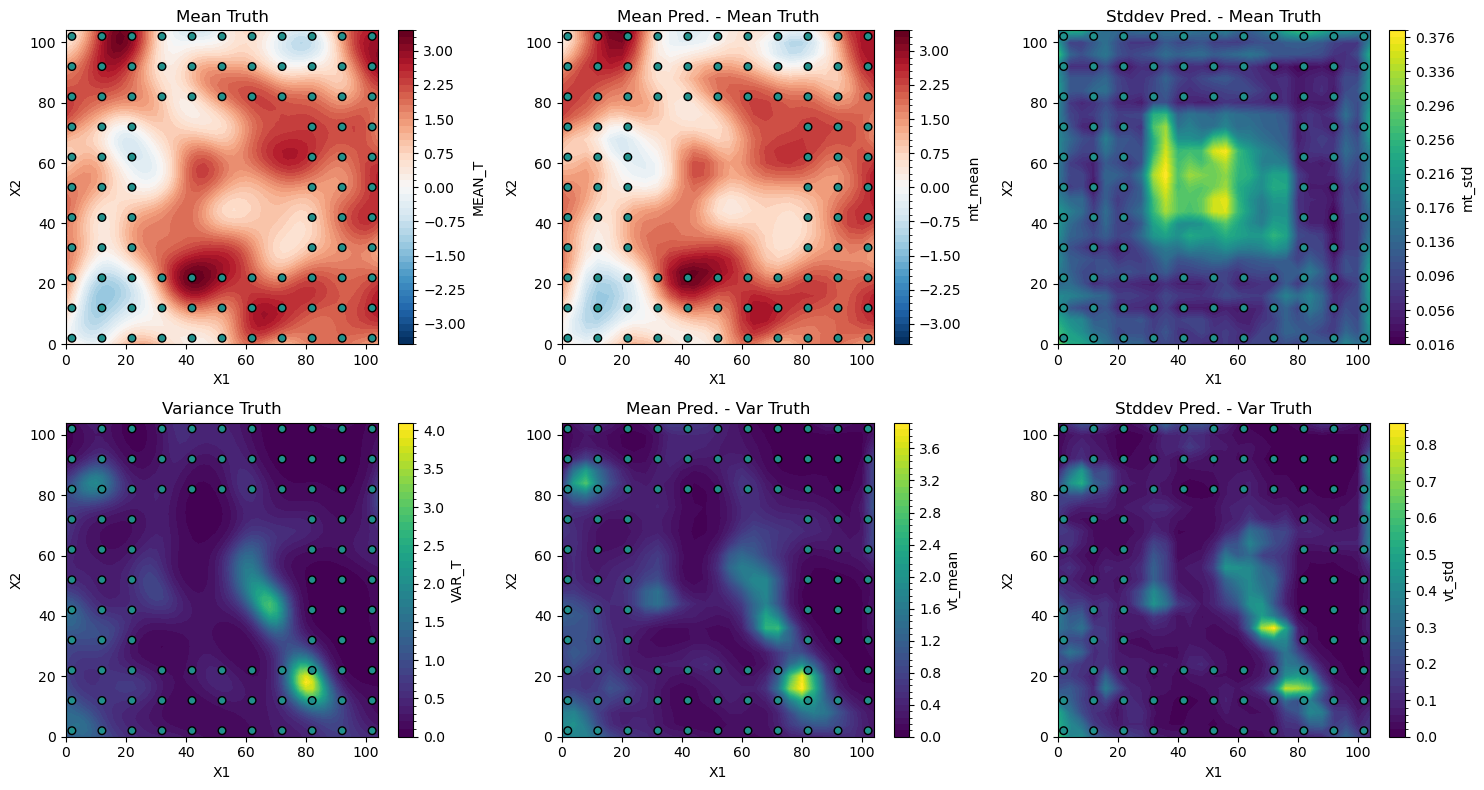

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
plots = []
variables = ['MEAN_T','VAR_T']
titles = ['Mean Truth','Variance Truth']
pred_variables = ['mt_mean','mt_std','vt_mean','vt_std']
pred_titles = ['Mean Pred. - Mean Truth','Stddev Pred. - Mean Truth','Mean Pred. - Var Truth','Stddev Pred. - Var Truth']

for i,var,title in zip([1,4], variables, titles):
    plt.subplot(2, 3, i)
    plots.append(ds[var].plot.contourf(x='X1',y='X2',levels=50))#,ax=axs.flatten()[0]))
    plt.title(title)

for i,var,title in zip([2,3,5,6], pred_variables, pred_titles):
    plt.subplot(2, 3, i)
    plots.append(
        ds_predictions[f'{var}'].plot.contourf(x='X1',y='X2',levels=50)
    )
    plt.title(title)

da = da_obs.isel(D=0)
da = da.where(da.isnull(),1)
for i in [0,1,2,3,4,5]:
    ax = axs.flatten()[i]
    da.to_dataset().plot.scatter(x='X1',y='X2',hue='T',s=30, facecolors='none', edgecolors='k',add_colorbar=False, ax=ax, add_title=False)

plt.tight_layout()

# https://docs.xarray.dev/en/stable/generated/xarray.plot.scatter.html

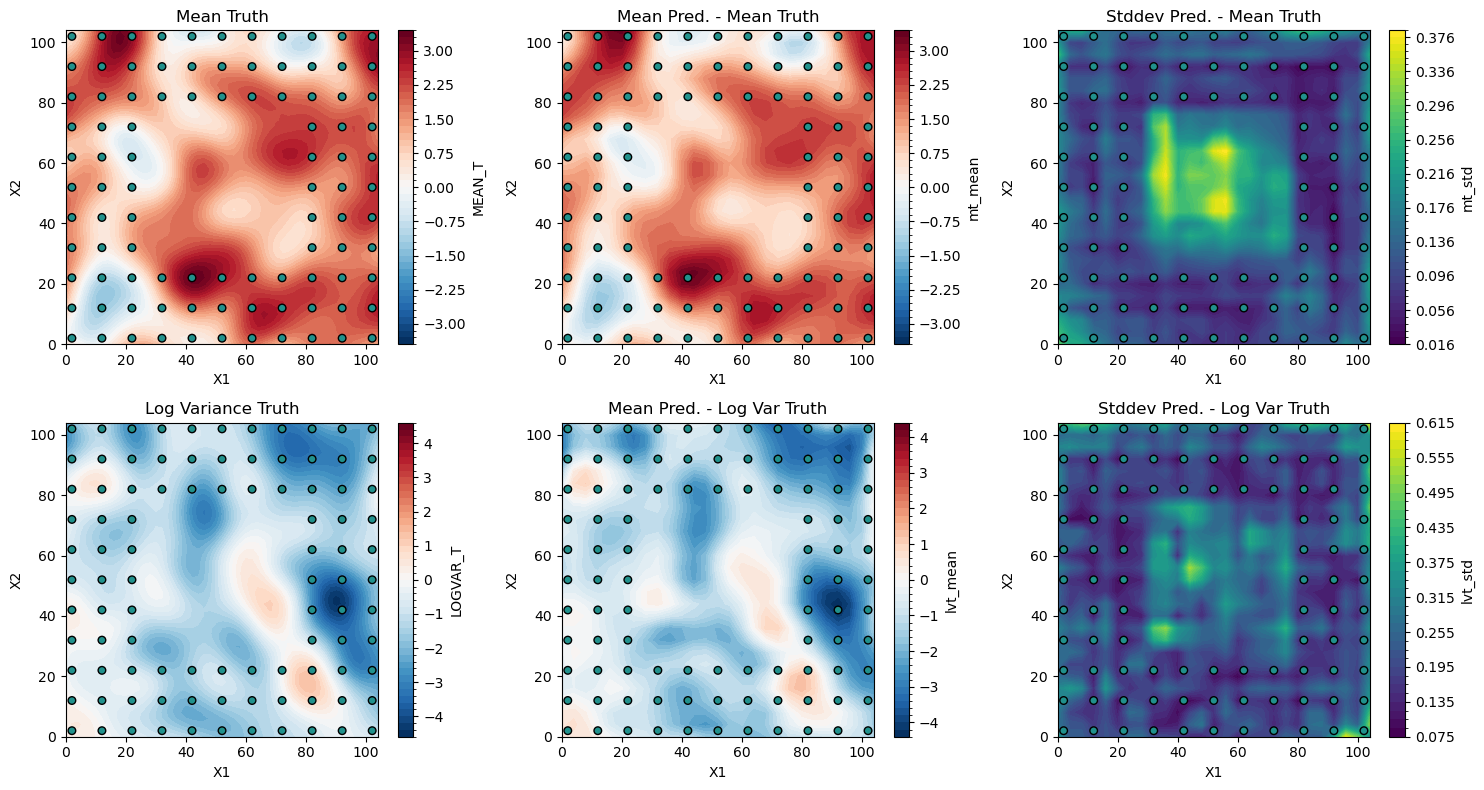

In [51]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
plots = []
variables = ['MEAN_T','LOGVAR_T']
titles = ['Mean Truth','Log Variance Truth']
pred_variables = ['mt_mean','mt_std','lvt_mean','lvt_std']
pred_titles = ['Mean Pred. - Mean Truth','Stddev Pred. - Mean Truth','Mean Pred. - Log Var Truth','Stddev Pred. - Log Var Truth']

for i,var,title in zip([1,4], variables, titles):
    plt.subplot(2, 3, i)
    plots.append(ds[var].plot.contourf(x='X1',y='X2',levels=50))#,ax=axs.flatten()[0]))
    plt.title(title)

for i,var,title in zip([2,3,5,6], pred_variables, pred_titles):
    plt.subplot(2, 3, i)
    plots.append(
        ds_predictions[f'{var}'].plot.contourf(x='X1',y='X2',levels=50)
    )
    plt.title(title)

da = da_obs.isel(D=0)
da = da.where(da.isnull(),1)
for i in [0,1,2,3,4,5]:
    ax = axs.flatten()[i]
    da.to_dataset().plot.scatter(x='X1',y='X2',hue='T',s=30, facecolors='none', edgecolors='k',add_colorbar=False, ax=ax, add_title=False)

plt.tight_layout()

# https://docs.xarray.dev/en/stable/generated/xarray.plot.scatter.html

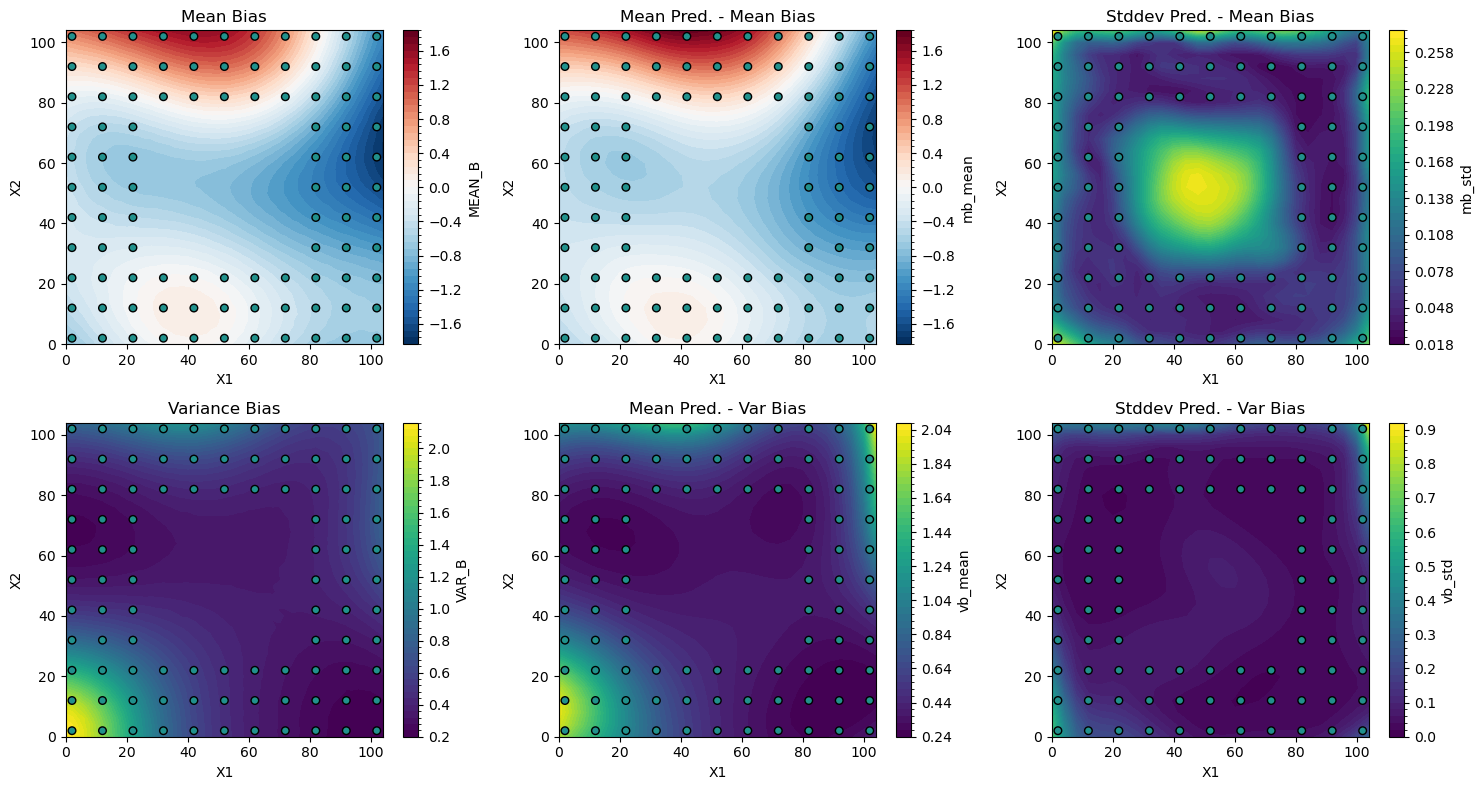

In [52]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
plots = []
variables = ['MEAN_B','VAR_B']
titles = ['Mean Bias','Variance Bias']
pred_variables = ['mb_mean','mb_std','vb_mean','vb_std']
pred_titles = ['Mean Pred. - Mean Bias','Stddev Pred. - Mean Bias','Mean Pred. - Var Bias','Stddev Pred. - Var Bias']

for i,var,title in zip([1,4], variables, titles):
    plt.subplot(2, 3, i)
    plots.append(ds[var].plot.contourf(x='X1',y='X2',levels=50))#,ax=axs.flatten()[0]))
    plt.title(title)

for i,var,title in zip([2,3,5,6], pred_variables, pred_titles):
    plt.subplot(2, 3, i)
    plots.append(
        ds_predictions[f'{var}'].plot.contourf(x='X1',y='X2',levels=50)
    )
    plt.title(title)

da = da_obs.isel(D=0)
da = da.where(da.isnull(),1)
for i in [0,1,2,3,4,5]:
    ax = axs.flatten()[i]
    da.to_dataset().plot.scatter(x='X1',y='X2',hue='T',s=30, facecolors='none', edgecolors='k',add_colorbar=False, ax=ax, add_title=False)

plt.tight_layout()

# https://docs.xarray.dev/en/stable/generated/xarray.plot.scatter.html

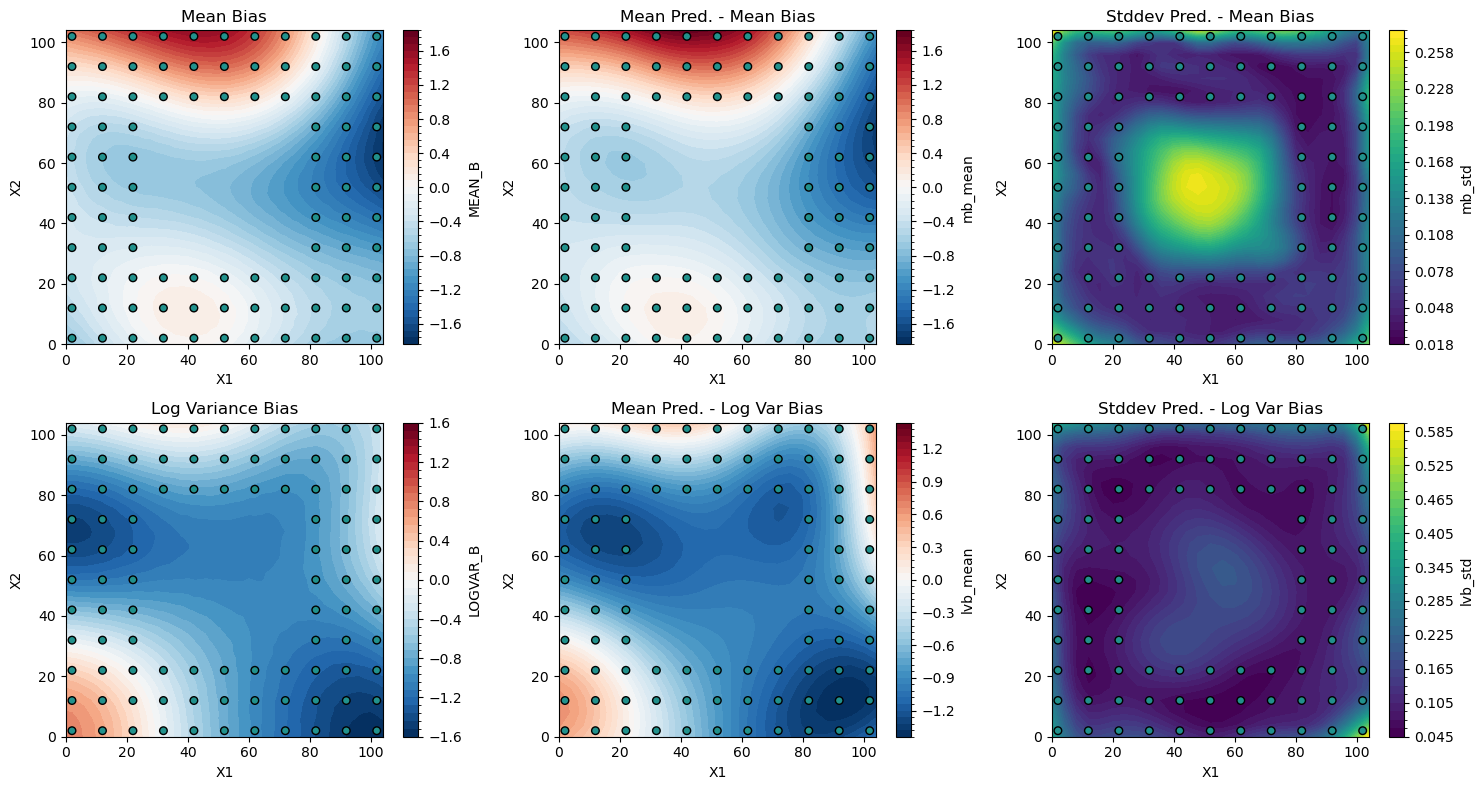

In [53]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
plots = []
variables = ['MEAN_B','LOGVAR_B']
titles = ['Mean Bias','Log Variance Bias']
pred_variables = ['mb_mean','mb_std','lvb_mean','lvb_std']
pred_titles = ['Mean Pred. - Mean Bias','Stddev Pred. - Mean Bias','Mean Pred. - Log Var Bias','Stddev Pred. - Log Var Bias']

for i,var,title in zip([1,4], variables, titles):
    plt.subplot(2, 3, i)
    plots.append(ds[var].plot.contourf(x='X1',y='X2',levels=50))#,ax=axs.flatten()[0]))
    plt.title(title)

for i,var,title in zip([2,3,5,6], pred_variables, pred_titles):
    plt.subplot(2, 3, i)
    plots.append(
        ds_predictions[f'{var}'].plot.contourf(x='X1',y='X2',levels=50)
    )
    plt.title(title)

da = da_obs.isel(D=0)
da = da.where(da.isnull(),1)
for i in [0,1,2,3,4,5]:
    ax = axs.flatten()[i]
    da.to_dataset().plot.scatter(x='X1',y='X2',hue='T',s=30, facecolors='none', edgecolors='k',add_colorbar=False, ax=ax, add_title=False)

plt.tight_layout()

# https://docs.xarray.dev/en/stable/generated/xarray.plot.scatter.html